In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# References

Abu-Ismail, O. (2021, November 23). How to correctly use ImageDataGenerator in Keras? Stack Overflow. https://stackoverflow.com/questions/70080062/how-to-correctly-use-imagedatagenerator-in-keras

Kolla, A. R. (2020). AlexNet CNN architecture on TensorFlow - Beginner [Kaggle notebook]. Kaggle. https://www.kaggle.com/code/vortexkol/alexnet-cnn-architecture-on-tensorflow-beginner

https://www.geeksforgeeks.org/what-is-the-input-size-of-alex-net/


**Step 1 : Brief Description of the problem and data**

In this Kaggle competition we are giving medical images, and we are tasked with classifying them as containing at least one pixel of tumor tissue - specifically, the center 32x32px region of the image. All images are 96x96 pixels. These are TIFF files, rather than tabular data that we've worked with in previous courses in this specialization. So, we must preprocess these images to a numerical representation, train a convolutional neural network, and then use it for a binary classification problem.

**Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

This is a binary classification problem. Let's see how balanced our data is (what the count of 0 and 1 is in the training data).

In [2]:
trainLabelsPath = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

train_labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

print(train_labels_df.head())

value_counts = train_labels_df['label'].value_counts()

print(value_counts)

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
label
0    130908
1     89117
Name: count, dtype: int64


Our data is not perfectly balanced - 131K 0's and 90K 1's. This is a pretty significant skew towards negative examples. We are going to undersample the negative examples, so we have 90K of each. This was done in a separate file and imported into this notebook as a new dataset for speed, but for educational purposes the code used to do it is below, commented out:

In [3]:
# trainLabelsPath = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
# train_labels_df = pd.read_csv(trainLabelsPath)
# source_dir = '/kaggle/input/histopathologic-cancer-detection/train'
# dest_dir_0 = '/kaggle/working/0'
# dest_dir_1 = '/kaggle/working/1'

# os.makedirs(dest_dir_0, exist_ok=True)
# os.makedirs(dest_dir_1, exist_ok=True)

# class_0_df = train_labels_df[train_labels_df['label'] == 0]
# class_1_df = train_labels_df[train_labels_df['label'] == 1]


# sampled_class_0_df = class_0_df.sample(n=len(class_1_df), random_state=42)
# balanced_df = pd.concat([sampled_class_0_df, class_1_df])


# for i, row in balanced_df.iterrows():
#     file_name = row['id'] + '.tif'  
#     label = row['label']
    
    
#     source_file = os.path.join(source_dir, file_name)
#     source_img = Image.open(source_file)
#     W, H = source_img.size
#     centerX, centerY = W / 2, H / 2
#     box = (centerX - 16, centerY - 16, centerX + 16, centerY + 16)
#     cropped_img = source_img.crop(box)
#     cleanedImage = cropped_img.resize((64, 64), Image.NEAREST)
    
#     dest_dir = dest_dir_0 if label == 0 else dest_dir_1
#     cleanedImage.save(f"{dest_dir}/{file_name}")

Our task is to use the center 32x32 window of our 96x96 images, to predict the presence of cancer. We can perform some simple pre-processing to improve the input data for our model. 

Since we are only going to examine the center 32x32 pixels, we can crop the rest of the image out entirely.

Once we have this cropped image, we can upscale it, to give a bigger and more detailed image to our model. This is a common technique in computer vison. Since we are working with limited resources, we will try upscaling to 64x64, using a nearest-neighbor algorithm. The code to accomplish this is in the cell below. It has been commented out, and its output has been saved as a separate dataset (preprocessed-data).

In [4]:
#Preprocessing training data
##This code will crop the center window of each image, upscale it to double its original size, and 
##then save it to either directory 0 or 1 depending on its label. Output was saved to the preproccessed-data dataset.
#An equivalent script was run to produce the preprocessed-data-alex file

# import os
# import shutil

# dest_dir_0 = '/kaggle/working/0'
# dest_dir_1 = '/kaggle/working/1'

# os.makedirs(dest_dir_0, exist_ok=True)
# os.makedirs(dest_dir_1, exist_ok=True)

# source_dir = '/kaggle/input/histopathologic-cancer-detection/train'
# for i, row in train_labels_df.iterrows():
#     file_name = row['id'] + '.tif'  
#     label = row['label']            

   
#     source_file = os.path.join(source_dir, file_name)
    
#     source_img = Image.open(source_file)
#     W, H = source_img.size
#     centerX = W/2
#     centerY = H/2
    
#     box = (centerX-16, centerY-16, centerX+16, centerY+16)
#     cropped_img = source_img.crop(box)
    
#     cleanedImage = cropped_img.resize((64,64), Image.NEAREST)
    
#     cleanedFile = None
    
#     if label == 0:
#         cleanedImage.save(f"{dest_dir_0}/{file_name}")

#     else:
#         cleanedImage.save(f"{dest_dir_1}/{file_name}")

    

We'll apply the same preprocessing to our test data below.

In [5]:
#Preprocessing test data

import os
from PIL import Image

# Directories


source_dir = '/kaggle/input/histopathologic-cancer-detection/test'
dest_dir = '/kaggle/working/test/all'  

os.makedirs(dest_dir, exist_ok=True)


for file_name in os.listdir(source_dir):
    if file_name.endswith('.tif'):  
        source_file = os.path.join(source_dir, file_name)
        
        source_img = Image.open(source_file)
        
        W, H = source_img.size
        centerX = W / 2
        centerY = H / 2
        box = (centerX - 16, centerY - 16, centerX + 16, centerY + 16)  # 32x32 crop
        
        cropped_img = source_img.crop(box)
        
        cleaned_img = cropped_img.resize((64, 64), Image.NEAREST)
        cleaned_img.save(os.path.join(dest_dir, file_name))

print("Processing complete.")


Processing complete.


With Keras, we create data generators, which feed images into our models in batches. With the large file sizes and computation costs, these are essential. I set up separate data generators for the train and test sets, using a batch size of 16. Initially, I used a batch size of 32, and this would cause my Kaggle notebook to freeze during training.

In [6]:
#Creating data generators for training and test

datagen = ImageDataGenerator(
)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/preprocessed-data-equal',
    target_size=(64,64),
    batch_size=16,         
    class_mode='binary'     
)

#Data generator for test

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    directory='/kaggle/working/test',  
    target_size=(64,64),  
    batch_size=16,  
    class_mode=None, 
    shuffle=False,  
    color_mode='rgb' 
)



Found 178234 images belonging to 2 classes.
Found 57458 images belonging to 1 classes.


Let's build some visualizations of the distribution of pixel intensity of red, blue and green values across the training dataset.

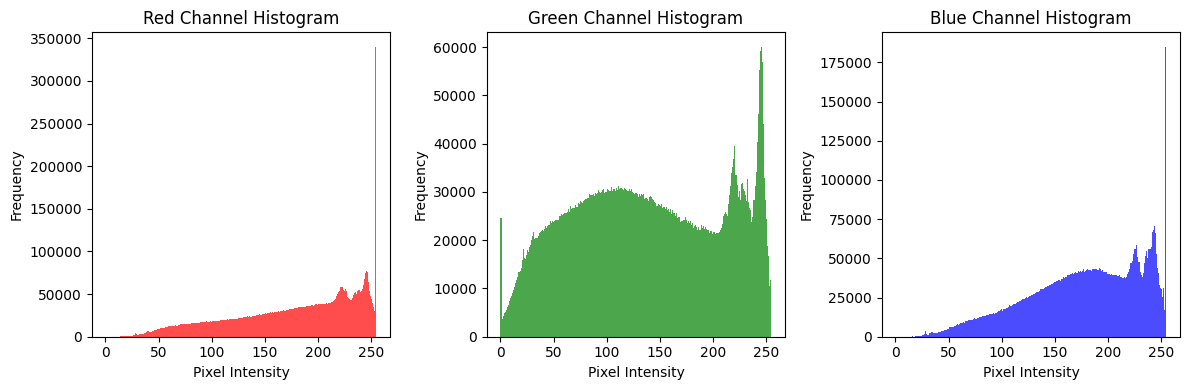

In [7]:
##histogram
all_red_channel = []
all_green_channel = []
all_blue_channel = []

num_batches_to_sample = 100
batches_processed = 0

for images, labels in train_generator:
    all_red_channel.extend(images[:, :, :, 0].ravel())
    all_green_channel.extend(images[:, :, :, 1].ravel())
    all_blue_channel.extend(images[:, :, :, 2].ravel())
    
    batches_processed += 1
    
    if batches_processed >= num_batches_to_sample:
        break

all_red_channel = np.array(all_red_channel)
all_green_channel = np.array(all_green_channel)
all_blue_channel = np.array(all_blue_channel)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(all_red_channel, bins=256, color='red', alpha=0.7)
plt.title('Red Channel Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(all_green_channel, bins=256, color='green', alpha=0.7)
plt.title('Green Channel Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(all_blue_channel, bins=256, color='blue', alpha=0.7)
plt.title('Blue Channel Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Step 3 Model Architecture

Given our relatively small image size, we will use a CNN with 3 convolution layers, two pooling layers, and a single-neuron sigmoid activation layer. Below we have a function that will build this base model, and has parameters for different optimizers, number of epochs, and learning rate.

In [8]:
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import SGD,Adam

def build_model_and_predict(opt,epochs, learning_rate, train_generator, test_generator):

    
    model = models.Sequential()
    model.add(Input(shape=(64, 64, 3))) 
    model.add(layers.Conv2D(32, (3, 3), activation='relu')) 
    model.add(layers.MaxPooling2D((2, 2))) 
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))  
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))  
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

 
    model.add(layers.Flatten())  
    model.add(layers.Dense(128, activation='relu')) 
    model.add(layers.Dropout(0.5)) 

    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    
    
    
    if opt == 'sgd':
        
        model.compile(
        optimizer=SGD(learning_rate=learning_rate, momentum=0.9, clipnorm=1.0),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc'), Recall(name='recall'), Precision(name='precision')])
    else:
        model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc'), Recall(name='recall'), Precision(name='precision')])
        

    history = model.fit(train_generator, epochs = epochs)
    train_accuracy = history.history['accuracy']  
    print(train_accuracy)
    
    predictions = model.predict(test_generator)
    print(predictions)
   
    predicted_classes = (predictions > 0.5).astype(int)
   
    filenames = test_generator.filenames
    filenames = [name.split('/')[-1].split('.')[0] for name in filenames]  
   
    results_df = pd.DataFrame({
        'id': filenames,
        'label': predicted_classes.flatten()
    })
  
    z = 'a' if learning_rate == 0.001 else 'b'
    
    results_df.to_csv(f"simple_model_{opt}_{epochs}_epochs_{z}pointzerozerotwo_10_7.csv", index=False)
    
    
    

The code below will iterate through different rates, optimizers, and epochs, building the model, training it, making predictions, and saving those predictions to a csv file suitable for uploading to Kaggle.

In [9]:
# rates = [0.001, 0.0002]
# opts = ['adam','sgd']
# epochs = [15, 50, 75]


# for e in epochs:
    
#     for r in rates:
        
#         for o in opts:
#             build_model_and_predict(o,e,r, train_generator, test_generator)


If you've completed this competition, you've likely noticed that Kaggle notebooks can only run for a maximum of 12 hours, even in "background" mode. So while the code above is useful, it's more of a theoretical implementation - to actually complete a run in less than 12 hours, at least for 100 epochs, I needed to manually run a single combination at a time.

For the sake of thoroughness, we'll examine a more complex CNN - the AlexNet architecture. It involves 5 convolution layers, with 128-256 filters, with pooling layers, normalization, and dropouts.

AlexNet is optimized for 227x227 images. To properly upscale our training data is just too resource-intensive, so we will show the algorithm, but AlexNet will not be part of our final results.

Below we will implement the AlexNet neural network (Kolla, 2020).

In [10]:
# def build_alex_model_and_predict(epochs, train_generator, test_generator):

    
#     model=keras.models.Sequential([
#     model.add(Input(shape=(64, 64, 3))),
#     keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(2,2)),
#     keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3)),
#     keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(2,2)),
#     keras.layers.Flatten(),
#     keras.layers.Dense(1024,activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(1024,activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(1,activation='sigmoid')  
    
    
# ])

#     model.compile(
#     loss='binary_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy', AUC(name='auc'), Recall(name='recall'), Precision(name='precision')]  
#     )

#     model.fit(train_generator, epochs = epochs)
    
#     predictions = model.predict(test_generator)
#     # Convert probabilities to binary labels (0 or 1)
#     predicted_classes = (predictions > 0.5).astype(int)
#     # Get filenames from the generator
#     filenames = test_generator.filenames
#     filenames = [name.split('/')[-1].split('.')[0] for name in filenames]  # Extract just the filename
#     # Create a DataFrame with the image IDs and their corresponding predictions
#     results_df = pd.DataFrame({
#         'id': filenames,
#         'label': predicted_classes.flatten()
#     })
#     # Save the predictions to a CSV file
#     z = 'a' if learning_rate == 0.001 else 'b'
    
#     results_df.to_csv(f"alex_model_{epochs}_epochs_{z}.csv", index=False)
#     return model.evaluate(test_generator)

In [11]:

# epochs = [20, 50, 100]

# for e in epochs:
#     results = build_alex_model_and_predict(e, alex_train_generator, alex_test_generator)
#     loss, accuracy, auc, recall, precision = results
#     print(f"Results with {r} learning rate, {o} optimizer, {e} epochs:")
#     print(f"Test Loss: {loss}")
#     print(f"Test Accuracy: {accuracy}")
#     print(f"Test AUC: {auc}")
#     print(f"Test Recall: {recall}")
#     print(f"Test Precision: {precision}")

# Step 4 Results and Analysis

Much of step 4's criteria was covered above - we tuned multiple hyperparameters iteratively. Below is a table summarizing the performance of the model architectures and hyperparameters:

| Optimizer | Epochs | Learning Rate | Score |
|-----------|--------|---------------|-------|
|     Adam      |    15    |        0.0001       |  .7677     |
|     Adam      |    50    |        0.0001       |   .7562    |
|     Adam      |    75    |        0.0001       |   .7740    |
|     SGD      |     50   |         0.0002      |   .8078    |
|           |        |               |       |


# Conclusion

This was the first project in the Machine Learning specialization with intensive image data. Adjusting to the computation time and dataset size was a significant challenge. 

Undersampling the training data would be one way to try out different architectures and hyperparameters more easily.

Upgrading to paid resources would make it much easier to try more ambitious architectures and preprocessing techniques, to improve our Kaggle score. The Alex model would certainly perform much better. In our training, even when using GPU accelerators, the maximum epochs our model achieved was around 75 epochs - more epochs could have improved our result, but for the scope of this project, we achieved a solid result. In our findings, the SGD optimizer was slightly more effective than the Adam optimizer.